

Before running this notebook you are required to download the trained models. The file structure can be adjusted, but it is setup to run out of the box as instructed below.
*   Download the provided IPYNB_DL_Metrology_UNet folder and its contents from [Google Drive](https://drive.google.com/drive/folders/1kNN6Yu0MOQ6yzHv4rivvOhWIil8lxdtT)
*   Place the IPYNB_DL_Metrology_UNet folder, containing: "images", "output_csv", "output_images", and "trained_models" in you "My Drive" google drive folder.
*   Turn on the GPU for faster runtimes!





In [ ]:
#Getting acces to your google drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/IPYNB_DL_Metrology_UNet/'

/content/drive/My Drive/IPYNB_DL_Metrology_UNet


In [ ]:
import os
import numpy as np
import cv2 as cv
import csv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# WHEN RUNNING MULTIPLE IMAGES START RERUNNING FROM HERE!!!
# >>> Runtime > RUN AFTER
# DO NOT RERUN THE CODE ABOVE!

# Example images are provided in the 'IPYNB_DL_Metrology_UNet/images/' folder
# These examples include:
# "PXL_20230220_113139588.MP.jpg"
# "PXL_20230220_121545802.MP.jpg"
# "PXL_20230220_122318396.MP.jpg"
# "PXL_20230221_095305038.MP.jpg"
# Add additional images to this folder if you want to test other images

# Change to change input image
INPUT_IMG = "PXL_20230220_113139588.MP.jpg"

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 3
IMAGE_HEIGHT = 720
IMAGE_WIDTH = 720

In [ ]:
IMAGE_DIR = "images/"
SAVE_DIR = "output_images/"
CSV_DIR = "output_csv/"
MODEL_DIR = "trained_models/"

In [ ]:
# Models to be loaded
MODEL_NAME_SIEVE = "sieve_epochs200_batch7_h720_w720_100xlr1e-4_100xlr1e-05_RandomResizedCrops_FocalLoss.pth.tar"
MODEL_NAME_SCOPE = "scope_epochs100_batch7_h720_w720_50xlr1e-04_50xlr1e-05_RandomResizedCrops.pth.tar"

In [ ]:
# Utils

# Load model at specified checkpoint
def load_checkpoint(model, folder, filename):
    if torch.cuda.is_available():
        print("=> Loading checkpoint")
        print(f"Filename = {filename}")
        checkpoint_path = os.path.join(folder, filename)
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["state_dict"])
    else:
        print("=> Loading checkpoint")
        print(f"Filename = {filename}")
        checkpoint_path = os.path.join(folder, filename)
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint["state_dict"])


# Make a prediction for the sieve segments and the lens segment
def predict(x, model_sieve, model_scope, device="cuda"):
    # Evaluation mode
    model_sieve.eval()
    model_scope.eval()

    x = x.to(device)

    with torch.no_grad():
        # Make prediction for the sieve module and turn into class labels
        pred_sieve = torch.argmax(model_sieve(x), dim=1).squeeze(0)
        pred_sieve = pred_sieve.cpu().numpy()

        # Make prediction for the lens module and turn into class labels
        pred_scope = torch.sigmoid(model_scope(x))
        pred_scope = (pred_scope > 0.5).float().squeeze(0, 1)
        pred_scope = pred_scope.cpu().numpy()


        pred_sieve[pred_sieve == 1] = 127
        pred_sieve[pred_sieve == 2] = 255
        pred_sieve = pred_sieve.astype(np.uint8)

        pred_scope[pred_scope == 1] = 255
        pred_scope = pred_scope.astype(np.uint8)

    # Turn training mode back on
    model_sieve.train()
    model_scope.train()

    return pred_sieve, pred_scope


def resize_image(img, width, height):
    transform_resize = A.Resize(width=width, height=height)

    resized_img = transform_resize(image=img)
    resized_img = resized_img["image"]

    return resized_img


def micron_to_pixel_ratio(scope_mask, og_width, og_height):
    # Reference width magnified view in microns
    # This calculation is constant but shown in the full code
    # This width in micron is identical for all images taken at the same magnification
    scope_in_micron = 305.6156405990017

    # Resize scope mask to it's original image size
    # this is mainly done to restore the picture to it's original aspect ratio
    scope_mask = resize_image(scope_mask, og_width, og_height)

    # Find scope contour
    scope_contour, _ = cv.findContours(scope_mask, cv.RETR_EXTERNAL , cv.CHAIN_APPROX_NONE)

    # Calculate the width of the scope in pixels of the scope mask
    _, _, scope_mask_width, _ = cv.boundingRect(scope_contour[0])

    micron_pixel_ratio = scope_in_micron / scope_mask_width

    return micron_pixel_ratio


def split_holes_debris(mask, segments):
    # Filter holes and blocked holes
    segment_dict = {"holes": {}, "debris": {}}

    for i, seg in enumerate(segments):
        # Create a mask for the current segment
        segment_mask = np.zeros_like(mask, dtype=np.uint8)
        cv.drawContours(segment_mask, [seg], -1, 255, cv.FILLED)

        # Calculate the mean value of the filled pixels within the contour
        pixel_value = np.max(mask[segment_mask == 255])

        # Blocked holes by debris
        if pixel_value == 255:
            segment_dict["debris"][f"seg{i}"] = Segment()
            segment_dict["debris"][f"seg{i}"].contour = seg
            continue

        # Open holes
        if pixel_value == 127:
            segment_dict["holes"][f"seg{i}"] = Segment()
            segment_dict["holes"][f"seg{i}"].contour = seg

            # calculate width, height, area of every hole
            area = cv.contourArea(seg)
            (x, y), (w, h), _ = cv.minAreaRect(seg)

            segment_dict['holes'][f"seg{i}"].area = area
            segment_dict['holes'][f"seg{i}"].width = w
            segment_dict['holes'][f"seg{i}"].height = h
            segment_dict['holes'][f"seg{i}"].x = x
            segment_dict['holes'][f"seg{i}"].y = y

    return segment_dict


def cal_avg_area_width_height(segment_dict):
    avg_area = np.mean([seg.area for seg in segment_dict.values()])
    avg_width = np.mean([seg.width for seg in segment_dict.values()])
    avg_height = np.mean([seg.height for seg in segment_dict.values()])

    return avg_area, avg_width, avg_height


def write_csv_report(csv_path, input1=None, input2=None, input3=None, input4=None,create_header1=False, create_header2=False):
    # Create new header for train / validation set
    if create_header1:
        header = ["debris_quantity", "mean_area", "mean_width", "mean_height"]
        with open(csv_path, "w", encoding="UTF8", newline="") as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(header)
            writer.writerow([input1, input2, input3, input4])

        return

    if create_header2:
        header = ["segment_center", "area", "width", "height"]
        with open(csv_path, "a", encoding="UTF8", newline="") as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(header)
        return

    # Add data row to train / validation csv
    with open(csv_path, "a", encoding="UTF8", newline="") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow([input1, input2, input3, input4])

In [ ]:
# Post-Processing

class Segment():
    def __init__(self):
        self.contour = None
        self.area = None
        self.width = None
        self.height = None
        self.x = None
        self.y = None
        self.error = None


#Remove background elements outside the area of the microscope's lens
def remove_background(segments, scope_mask):
    remaining_mask_segments = []

    # Iterate over the mask segments and check if their contour lies ether completely or partly outside the scope contour
    for i, seg in enumerate(segments):
        # Create a binary blank image with the same size as the scope mask image
        segment_mask = np.zeros(scope_mask.shape[:2], dtype=np.uint8)
        # Add the segment of interest to the segment mask
        cv.drawContours(segment_mask, [seg], 0, (255), thickness=cv.FILLED)

        # Compute the difference between the segment maks and the scope mask
        dif = cv.subtract(segment_mask, scope_mask)

        # If the difference between the 2 masks is bigger than 0 at some pixel location
        # It means the pixel of the segment at that location falls outside the scope mask
        # Check if the difference is non-zero
        # And remove (skip) segment if this is the case
        if np.any(dif > 0):
            continue

        # Else add it to the remaining mask segments that fall inside the scope region
        remaining_mask_segments.append(seg)

    return remaining_mask_segments


def create_scope_mask(pred_scope):
    # Perform morphological closing to close small gaps and smooth the boundaries of objects.
    kernel_size = 11
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (kernel_size, kernel_size))
    scope_closed = cv.morphologyEx(pred_scope, cv.MORPH_CLOSE, kernel)

    # Find the contours in the scope prediction
    contours, _ = cv.findContours(scope_closed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    # Find the largest contour -> this being the scope
    scope_contour = max(contours, key=cv.contourArea)

    # Create a binary image with the same size as the original scope image
    scope_mask = np.zeros(pred_scope.shape[:2], dtype=np.uint8)
    # Draw the scope contour as filled white pixels on the binary image
    cv.drawContours(scope_mask, [scope_contour], 0, (255), thickness=cv.FILLED)

    return scope_mask, scope_contour


# Calculate center point of a contour
def calc_center(contour):
    M = cv.moments(contour)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    return cx, cy


# Resize a contour around it's center point
def rescale_contour(contour, center_x, center_y, scale_size):
    contour_array = np.array(contour)
    scaled_contour = contour_array - [center_x, center_y]
    scaled_contour = scaled_contour * scale_size
    scaled_contour += [center_x, center_y]
    scaled_contour = (np.rint(scaled_contour)).astype(int)

    return scaled_contour


# Resize the region of interest
def scale_scope(pred_scope, scope_contour, scale_size):
    # Calculate the center point of scope contour
    scope_center_x, scope_center_y = calc_center(scope_contour)

    # Scale the contour of the scope around it's center point
    # Reduce its area by 20% (default)
    scaled_scope_contour = rescale_contour(scope_contour, scope_center_x, scope_center_y, scale_size)

    # Create a scaled scope mask
    scaled_scope_mask = np.zeros(pred_scope.shape[:2], dtype=np.uint8)
    # Draw the scaled scope contour as filled white pixels on the binary image
    cv.drawContours(scaled_scope_mask, [scaled_scope_contour], 0, (255), thickness=cv.FILLED)

    return scaled_scope_mask


# Remove all (remaining) sieve segments that fall partially or completely outside the scaled scope
def remove_segments(segments, scope_mask, margin):
    segments_of_interest = []
    # Removing edge holes that are cut-off by the scaled scope as these provide no valid info
    for i, seg in enumerate(segments):
        # Create a binary blank image with the same size as the mask image
        segment_mask = np.zeros(scope_mask.shape[:2], dtype=np.uint8)
        # Add the segment of interest to the segment mask
        cv.drawContours(segment_mask, [seg], 0, (255), thickness=cv.FILLED)

        # Compute the difference between the segment maks and the scope mask
        dif = cv.subtract(segment_mask, scope_mask)

        # number of pixels outside the scaled scope.
        pixels_outside = np.sum(dif > 0)
        # total number of pixels of the segment
        total_segment_pixels = np.sum(segment_mask > 0)

        # Remove (skip) segments that have more than 5% of their pixels fall outside the scope area
        if pixels_outside / total_segment_pixels > margin:
            continue

        segments_of_interest.append(seg)

    return segments_of_interest


#Calculate the average area of a list of segments
def calc_avg_area(contours):
    if len(contours) <= 0:
        return 0

    areas = np.array([cv.contourArea(contour) for contour in contours])
    return areas.mean()

# Remove small segments
def remove_noise(segments, threshold):
    average_area = calc_avg_area(segments)
    remaining_segments = []

    for seg in segments:
        if cv.contourArea(seg) < average_area * threshold:
            continue
        remaining_segments.append(seg)

    return remaining_segments


# Fuse segments that partially containing pixels of both the debris/hole class
def fuse_segments(segments, mask, new_mask, threshold):
    for seg in segments:
        # Create a blank mask for the current segment
        count_mask = np.zeros_like(mask)
        # Fill it with the contour of the segment
        cv.fillPoly(count_mask, [seg], color=(255, 255, 255))

        # The region a single segment in the original mask
        roi = cv.bitwise_and(mask, count_mask)

        # Count the number of pixels per class in the segment
        hole_pixels = np.count_nonzero(roi == 127)
        debris_pixels = np.count_nonzero(roi == 255)
        total_pixels = hole_pixels + debris_pixels

        # If atleast 20% of the pixels are off the debris class
        if debris_pixels >= total_pixels * threshold:
            # Set all pixels of the segment to 255
            new_mask[np.where(roi != 0)] = 255
        else:
            new_mask[np.where(roi != 0)] = 127

    return new_mask


# Run full post processing pipeline
def post_process(pred_sieve, pred_scope, true_label=None, eval=False):

    scope_mask, scope_contour = create_scope_mask(pred_scope)

    # Find all segments in the predicted mask image
    mask_contours, _ = cv.findContours(pred_sieve, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    # Remove all segments from the mask prediction image that fall outside the scope area
    # Thus remove all background segments
    remaining_mask_segments = remove_background(mask_contours, scope_mask)

    # Create a scaled scope mask reducing its area by 20%
    scaled_scope_mask = scale_scope(pred_scope, scope_contour, scale_size=0.8)

    # Remove all (remaining) sieve segments that fall partially or completely outside the scaled scope
    # with a margin of 5%
    segments_of_interest = remove_segments(remaining_mask_segments, scaled_scope_mask, 0.05)

    # Remove segments that have an area of less than 50% the average area
    remaining_segments = remove_noise(segments_of_interest, 0.5)

    # Create the segments of interest as a new image
    # Create a blank image with the same size as the mask image
    new_mask = np.zeros_like(pred_sieve)
    # Fill the mask with only the contour area's
    for seg in remaining_segments:
        cv.fillPoly(new_mask, [seg], color=(255, 255, 255))
    # Perform a bitwise and operation between the original image and  the mask
    # Restoring the original mask pixel values ast the positoin of the segemnts
    # Keeping the rest of the mask blank
    new_mask = cv.bitwise_and(pred_sieve, new_mask)

    # Fuse segments where 25% of the total pixels are off the debris class together
    # Making the entire segment debris, else make the entire segment hole
    new_mask = fuse_segments(remaining_segments, pred_sieve, new_mask, 0.25)

    # not in eval mode only return the post processed sieve mask
    if not eval:
        return new_mask, scope_mask, scaled_scope_mask

    # remove the edge holes
    # Find all segments in the true mask image
    true_contours, _ = cv.findContours(true_label, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    # Remove all (remaining) sieve segments that fall partially or completely outside the scaled scope
    # with a margin of 5%
    true_seg_interest = remove_segments(true_contours, scaled_scope_mask, 0.05)

    # Create ground truth mask for region of interest
    new_true = np.zeros_like(true_label)
    for seg in true_seg_interest:
        cv.fillPoly(new_true, [seg], color=(255, 255, 255))
    new_true = cv.bitwise_and(true_label, new_true)

    return new_mask, new_true

In [ ]:
# Unet Model

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels, n_classes, features=[64, 128, 256, 512]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path (down)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Expanding path (up)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)


    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Step size of 2 because ups contains a upsampling step follow by a double conv
        for idx in range(0, len(self.ups), 2):
            # Do the upsampling step
            x = self.ups[idx](x)
            feature_map = skip_connections[idx//2]

            if x.shape != feature_map.shape:
                x = TF.resize(x, size=feature_map.shape[2:])

            # Concatenate down and up feature maps from corresponding levels
            concat = torch.cat((feature_map, x), dim=1)
            # Do the double convolutions
            x = self.ups[idx+1](concat)

        return self.final_conv(x)

In [ ]:
# Inference Pipeline

# Load the image
img_path = os.path.join(IMAGE_DIR, INPUT_IMG)
img = np.array(Image.open(img_path).convert("RGB"))

img_height, img_width = img.shape[:2]

# Resize + normalize the image to the trained model HxW
transform = A.Compose(
    [
        A.Resize(height=720, width=720),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ]
)

img_resized = transform(image=img)
img_resized = img_resized['image']

# Add batch dimension
img_resized = img_resized.clone().detach().unsqueeze(0)

# Load trained model SIEVE
model_sieve = UNET(in_channels=3, n_classes=N_CLASSES).to(DEVICE)
load_checkpoint(model_sieve, MODEL_DIR, MODEL_NAME_SIEVE)

# Load trained model SCOPE
model_scope = UNET(in_channels=3, n_classes=1).to(DEVICE)
load_checkpoint(model_scope, MODEL_DIR, MODEL_NAME_SCOPE)

# Predict segmentation masks
pred_sieve, pred_scope = predict(img_resized, model_sieve, model_scope, device=DEVICE)

# Apply post-processing procedure
post_pred_sieve, scope_mask, scaled_scope_mask = post_process(pred_sieve, pred_scope, eval=False)

# Micron to pixel ratio for this image
micron_pixel_ratio = micron_to_pixel_ratio(scope_mask, img_width, img_height)

# Resize back to orignal image dimensions
transform_resize = A.Resize(width=img_width, height=img_height)
resized_prediction= transform_resize(image=post_pred_sieve)
resized_prediction = resized_prediction["image"]

# Create visual representation of the segmentation mask
# Create CSV report
img_copy = img.copy()
overlay_img = img.copy()

segment_contours, _ = cv.findContours(resized_prediction, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
segment_dict = split_holes_debris(resized_prediction, segment_contours)

# CSV Report -> First 2 lines
m_area, m_width, m_height = cal_avg_area_width_height(segment_dict['holes'])
m_area *= micron_pixel_ratio
m_width *= micron_pixel_ratio
m_height *= micron_pixel_ratio
number_debris = len(segment_dict['debris'])

csv_name = INPUT_IMG.replace(".MP.jpg", ".csv")
csv_path = os.path.join(CSV_DIR, f"{csv_name}")
write_csv_report(csv_path, number_debris, m_area, m_width, m_height, create_header1=True)
write_csv_report(csv_path, create_header2=True)

# Loop over all hole segments, measure their dimensions + create segmentation overlay
for segment in segment_dict['holes']:
    cv.drawContours(img_copy, [segment_dict['holes'][segment].contour], -1, (255, 0, 0), 8)
    overlay_img = cv.fillPoly(overlay_img, pts=[segment_dict['holes'][segment].contour], color=(225, 105, 65),
                                lineType=cv.LINE_AA)

    # Add the individual dimensions of every hole in microns to the csv report
    area = segment_dict['holes'][segment].area * micron_pixel_ratio
    width = segment_dict['holes'][segment].width * micron_pixel_ratio
    height = segment_dict['holes'][segment].height * micron_pixel_ratio
    cont = segment_dict['holes'][segment].contour
    # Calculate the moments of the contour
    M = cv.moments(cont)
    # Calculate the center of the contour
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    center = [cx, cy]

    write_csv_report(csv_path, center, area, width, height)

# Create segmentation overlay for all debris segments.
for segment in segment_dict['debris']:
    cv.drawContours(img_copy, [segment_dict['debris'][segment].contour], -1, (226, 43, 138), 6)
    overlay_img = cv.fillPoly(overlay_img, pts=[segment_dict['debris'][segment].contour], color=(226, 43, 138),
                                lineType=cv.LINE_AA)

# Opacity of segment overlay
alpha = 0.3
output = cv.addWeighted(overlay_img, alpha, img_copy, 1 - alpha, 0)

=> Loading checkpoint
Filename = sieve_epochs200_batch7_h720_w720_100xlr1e-4_100xlr1e-05_RandomResizedCrops_FocalLoss.pth.tar
=> Loading checkpoint
Filename = scope_epochs100_batch7_h720_w720_50xlr1e-04_50xlr1e-05_RandomResizedCrops.pth.tar


In [ ]:
# Load the csv file and display the first 10 rows
data = pd.read_csv(csv_path)
data.head(10)

,debris_quantity,mean_area,mean_width,mean_height
0,1,8250.406562201186,31.034647781280807,30.61327481112853
1,segment_center,area,width,height
2,"[2248, 2329]",8003.5972736624035,30.437861003924816,30.507459694276704
3,"[2719, 2325]",8181.293232819791,30.936224214750087,30.722132697692995
4,"[2239, 1859]",8420.379934493301,31.549421181184353,30.851647350482995
5,"[2703, 1848]",8665.996427437052,31.364407248864275,31.364407248864275
6,"[3173, 1838]",8098.332769960168,30.914591615477136,30.281228832777103
7,"[1773, 1401]",7548.759845674607,30.070564165106497,29.06670636861258
8,"[2223, 1389]",7994.391338428948,29.544629353878978,31.364407248864275
9,"[2693, 1374]",8342.557668043048,30.530706081535286,31.53525643481656


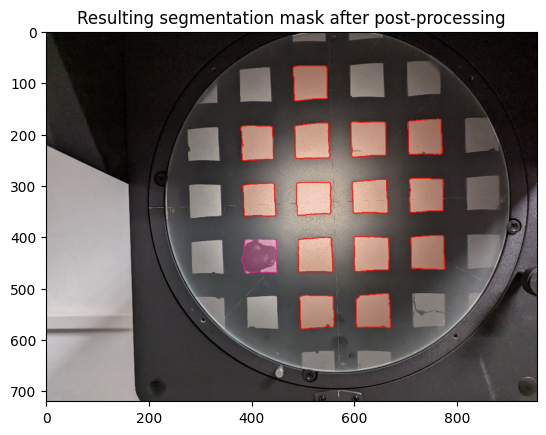

In [ ]:
# Resize output segmentation mask specify wanted dimensions
output = cv.resize(output, (956, 720))

# Plot Segmentations overlaid on the input image
plt.imshow(output)
plt.title("Resulting segmentation mask after post-processing")
plt.show()

In [ ]:
# Save visual representation of the overlay for inspection.
img_name = INPUT_IMG.replace(".MP.jpg", ".png")

cv.imwrite(f"{SAVE_DIR}/pred_{img_name}", output)

True